In [4]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
import csv
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch


In [5]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import PConvUNet2D
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec
from src.losses import calculate_metrics, improved_loss
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple
complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/hpc/home/srs108/TEMPO/pandora_filtered_data.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")

In [6]:
def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)


In [7]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min"):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    def sample_vis(self, idx=None, train=None, shp_path='/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"', seed=42):
        if idx is None:
            idx = np.random.randint(len(self))

        # Use the dataset's train flag if not explicitly provided
        if train is None:
            train = self.train

        sample = self[idx]

        inp_np = sample["masked_img"][0].numpy()
        known_mask = sample["known_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()

        # Get Pandora data if available
        p_mask = sample.get('p_mask', None)
        p_val_map = sample.get('p_val_map', None)

        # Calculate vmin/vmax for consistent scaling
        vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        # Get image metadata for Pandora plotting
        path = sample["path"]
        date_str = path.split('/')[-1].split('.')[0]
        date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

        # Get georeferencing info for Pandora
        with rasterio.open(path) as src:
            tr = src.transform
            crs = src.crs
            H, W = src.height, src.width

        ts = self._parse_time_from_fname(os.path.basename(path))
        xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

        # Load shapefile segments if provided
        segments = []
        if shp_path:
            segments = load_shapefile_segments_pyshp(shp_path, crs)

        def _add_shape_and_pandora(ax, plot_pandora=True):
            """Helper function to add shapefile and Pandora stations"""
            # Add shapefile
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))

            # Add Pandora stations if available and requested
            if plot_pandora and hasattr(self, 'pandora_df') and self.pandora_df is not None and ts is not pd.NaT:
                # Filter Pandora data for this timestamp
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()

                if not dfw.empty:
                    if "station" in dfw.columns:
                        dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                        dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                    # Create color map for stations
                    stations_all = self.pandora_df["station"].unique()
                    color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

                    # Get coordinates
                    lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

                    if ok_ll.sum() > 0:
                        dfw = dfw.loc[ok_ll].copy()
                        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
                        labels = dfw["station"].astype(str).to_numpy()

                        rr_i = rr.astype(int)
                        cc_i = cc.astype(int)
                        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
                        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

                        if rr_i.size > 0:
                            xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

                            for x, y, lab in zip(xs, ys, labels):
                                c = color_map.get(lab, "red")

                                # Plot with white halo + colored marker + black edge
                                ax.scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
                                sc = ax.scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)
                                sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'), pe.Normal()])

                            return True, color_map, labels  # Return info for legend

            return False, {}, []

        if train:
            # For training dataset, we have the realistic gaps
            realistic_gaps = sample['fake_mask'][0].numpy().astype(bool)
            all_masks = sample["known_and_fake_mask"][0].numpy().astype(bool)

            # SEPARATE THE GAPS: Extract only the gap pixels (not the original missing data)
            gaps_only_mask = known_mask & (~realistic_gaps)  # Areas that are known but made into gaps

            # Print statistics
            original_missing = (~known_mask).sum()
            gaps_only = gaps_only_mask.sum()
            all_artificial = (~realistic_gaps).sum()
            total_holes = (~all_masks).sum()
            gap_percentage = 100 * gaps_only / known_mask.sum()

            fig, ax = plt.subplots(1, 4, figsize=(26, 6))

            # Panel 1: Input (masked with all masks) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~all_masks), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input {idx} (all masks)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

#             # Panel 2: Original missing data (sensor holes)
#             ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
#             ax[1].set_title("Original Missing Data")

            # Panel 3: GAPS ONLY (artificial holes in previously known areas)
            ax[1].imshow(gaps_only_mask, cmap="Blues", alpha=0.7)
            ax[1].set_title(f"Gaps Only {gap_percentage:.1f}%")

            # Panel 4: Combined mask (all holes)
            ax[2].imshow(all_masks == 0, cmap="gray", alpha=0.7)
            ax[2].set_title("All Masks Combined")

            # Panel 5: Original target + Pandora
            im4 = ax[3].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[3].set_title(f"Original Target\n{date}")
            ax[3].set_xlim(xmin, xmax)
            ax[3].set_ylim(ymin, ymax)
            ax[3].set_aspect('equal')
            fig.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 5
            _add_shape_and_pandora(ax[3], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=15, markerscale=1.2)

            for a in ax[1:4]:  # Skip panels with geographic coords
                a.axis("off")

            plt.tight_layout()
            plt.show()

        else:
            # Validation dataset: show only 3 panels (no artificial gaps)
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))

            # Panel 1: Input (masked with known mask only) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~known_mask), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input {idx} (original mask)\n{date} ")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

            # Panel 2: Original missing data
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: Original target + Pandora
            im2 = ax[2].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[2].set_title(f"Original Target\n{date}")
            ax[2].set_xlim(xmin, xmax)
            ax[2].set_ylim(ymin, ymax)
            ax[2].set_aspect('equal')
            fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 3
            _add_shape_and_pandora(ax[2], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=15, markerscale=1.2)

            ax[1].axis("off")  # Only turn off axis for the middle panel

            plt.tight_layout()
            plt.show()
        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 

        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()

                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # Get station names for valid coordinates - FIXED VERSION
                dfw_ok = dfw.loc[ok].reset_index(drop=True)  # Filter dataframe to match valid coordinates
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): 
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): 
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: 
                    vals_n = vals.astype(np.float32)  # identity

                # Store Pandora data and station names
                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))

                    # Add corresponding station name
                    if i < len(station_names_raw):
                        station_names.append(station_names_raw[i])
                    else:
                        station_names.append(f"Unknown_{i}")

                val_list = vals_n.tolist()

        if self.train:
            n_blobs = np.random.randint(0, 5)
            realistic_gaps = generate_realistic_gaps_simple(
                                    shape=(H, W), 
                                    tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                    n_blobs=n_blobs, 
                                    blob_size_range=(20, 74),  # Can make even larger
                                    threshold=0.6
                                )

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,  # Add station names to sample
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  
                "path": path,
            }
            return sample

        else:
            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,  # Add station names to sample
                "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  
                "path": path
            }

            return sample

            if self.train:
                n_blobs= np.random.randint(0,5)
                realistic_gaps = generate_realistic_gaps_simple(
                                        shape=(H, W), 
                                        tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                        n_blobs=n_blobs, 
                                        blob_size_range=(20, 74),  # Can make even larger
                                        threshold=0.6
                                    )

                all_masks = known_mask * realistic_gaps
                img_with_holes = img_n * all_masks


                sample = {
                    "p_mask": torch.from_numpy(pandora_mask),
                    "p_val_mask": torch.from_numpy(pandora_val_map),
                    "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                    "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
                    "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                    "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          # salt/pepper holes
                    "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                    "path": path,
                    "station_names": station_names
                }
                return sample

            else:
                sample = {
                    "p_mask": torch.from_numpy(pandora_mask),
                    "p_val_mask": torch.from_numpy(pandora_val_map),
                    "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                    "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                    "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                    "path": path,
                    "station_names": station_names}

                return sample

In [9]:
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length station names"""
    
    # Separate the station_names from other tensor data
    collated_batch = {}
    
    # Handle tensor data normally
    tensor_keys = ['p_mask', 'p_val_mask', 'masked_img', 'known_mask', 'target']
    if 'known_and_fake_mask' in batch[0]:
        tensor_keys.append('known_and_fake_mask')
    if 'fake_mask' in batch[0]:
        tensor_keys.append('fake_mask')
    
    for key in tensor_keys:
        collated_batch[key] = torch.stack([item[key] for item in batch])
    
    # Handle paths as list
    collated_batch['path'] = [item['path'] for item in batch]
    
    # Handle station_names as list of lists (don't try to stack)
    collated_batch['station_names'] = [item['station_names'] for item in batch]
    
    return collated_batch

In [10]:
def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)

In [8]:
# model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
# model.load_state_dict(torch.load('/work/srs108/outputs/pconvunet.pt'))


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention2D(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(SelfAttention2D, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction
        
        # Query, Key, Value projections
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Output projection
        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Learnable parameter to control attention influence
        self.gamma = nn.Parameter(torch.zeros(1))
        
        # Normalization
        self.norm = nn.LayerNorm([in_channels])
        
    def forward(self, x, mask=None):
        batch_size, C, H, W = x.size()
        
        # Generate Q, K, V
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # [B, HW, C//r]
        key = self.key(x).view(batch_size, -1, H * W)  # [B, C//r, HW]
        value = self.value(x).view(batch_size, -1, H * W)  # [B, C, HW]
        
        # Compute attention scores
        attention = torch.bmm(query, key)  # [B, HW, HW]
        
        # Apply mask to attention if provided
        if mask is not None:
            mask_flat = mask.view(batch_size, 1, H * W)  # [B, 1, HW]
            mask_matrix = torch.bmm(mask_flat.transpose(1, 2), mask_flat)  # [B, HW, HW]
            attention = attention * mask_matrix
            attention = attention.masked_fill(mask_matrix == 0, float('-inf'))
        
        # Softmax normalization
        attention = F.softmax(attention, dim=-1)  # [B, HW, HW]
        
        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))  # [B, C, HW]
        out = out.view(batch_size, C, H, W)  # [B, C, H, W]
        
        # Output projection
        out = self.out_proj(out)
        
        # Residual connection with learnable parameter
        out = self.gamma * out + x
        
        # Layer normalization
        out = out.permute(0, 2, 3, 1)  # [B, H, W, C]
        out = self.norm(out)
        out = out.permute(0, 3, 1, 2)  # [B, C, H, W]
        
        return out

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class PConv2D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, use_bias=True, activation=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.activation = activation if activation is not None else nn.Identity()

        # Image kernel
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride,
                              padding=kernel_size // 2, bias=use_bias)

        # Fixed mask kernel (all ones)
        self.register_buffer("mask_kernel",
                             torch.ones(1, 1, kernel_size, kernel_size))

    def forward(self, img, mask):
        # Apply mask to image
        img_masked = img * mask

        # Convolution
        img_out = self.conv(img_masked)

        # Convolve mask (counts valid pixels)
        with torch.no_grad():
            mask_out = F.conv2d(mask, self.mask_kernel,
                                stride=self.stride, padding=self.kernel_size // 2)
            mask_out = torch.clamp(mask_out, 0, 1)

        # Normalize by valid ratio
        n = self.kernel_size * self.kernel_size
        mask_ratio = n / (mask_out + 1e-8)
        mask_ratio = mask_ratio * mask_out
        img_out = img_out * mask_ratio

        return self.activation(img_out), mask_out
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightweightSelfAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(LightweightSelfAttention, self).__init__()
        self.in_channels = in_channels
        
        # Much smaller attention dimensions
        hidden_dim = max(in_channels // reduction, 8)
        
        # Use 1x1 convs for efficiency
        self.query = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        self.key = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        self.value = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        self.out = nn.Conv2d(hidden_dim, in_channels, kernel_size=1)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x, mask=None):
        batch_size, C, H, W = x.size()
        
        # Downsample for attention computation (reduces memory)
        if H > 32 or W > 32:
            x_down = F.adaptive_avg_pool2d(x, (min(H, 32), min(W, 32)))
            h, w = x_down.shape[2], x_down.shape[3]
        else:
            x_down = x
            h, w = H, W
        
        # Compute attention on downsampled feature
        q = self.query(x_down).view(batch_size, -1, h * w).permute(0, 2, 1)
        k = self.key(x_down).view(batch_size, -1, h * w)
        v = self.value(x_down).view(batch_size, -1, h * w)
        
        attention = torch.bmm(q, k)
        attention = F.softmax(attention, dim=-1)
        
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch_size, -1, h, w)
        out = self.out(out)
        
        # Upsample back to original size if needed
        if h != H or w != W:
            out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)
        
        return self.gamma * out + x

class SimpleChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 4, in_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class EfficientPConvUNet2D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32, attention_layers=[4]):
        """
        attention_layers: list of encoder levels to apply attention (0-4)
        Example: [4] = only bottleneck, [3,4] = enc4 and bottleneck
        """
        super().__init__()
        self.attention_layers = attention_layers

        # Encoder
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))

        # Selective attention - only where specified
        self.attentions = nn.ModuleDict()
        if 1 in attention_layers:
            self.attentions['1'] = SimpleChannelAttention(base_ch)
        if 2 in attention_layers:
            self.attentions['2'] = SimpleChannelAttention(base_ch*2)
        if 3 in attention_layers:
            self.attentions['3'] = SimpleChannelAttention(base_ch*4)
        if 4 in attention_layers:
            self.attentions['4'] = LightweightSelfAttention(base_ch*8, reduction=8)

        # Bottleneck
        self.bot = PConv2D(base_ch*8, base_ch*8, activation=nn.LeakyReLU(0.1))
        if 'bot' in [str(x) for x in attention_layers] or 5 in attention_layers:
            self.attentions['bot'] = LightweightSelfAttention(base_ch*8, reduction=8)

        # Decoder - simplified
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        # Simple final layer
        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, img, mask):
        # Encoder
        e1, m1 = self.enc1(img, mask)
        if '1' in self.attentions:
            e1 = self.attentions['1'](e1)

        e2, m2 = self.enc2(e1, m1)
        if '2' in self.attentions:
            e2 = self.attentions['2'](e2)

        e3, m3 = self.enc3(e2, m2)
        if '3' in self.attentions:
            e3 = self.attentions['3'](e3)

        e4, m4 = self.enc4(e3, m3)
        if '4' in self.attentions:
            e4 = self.attentions['4'](e4, m4)

        # Bottleneck
        b, mb = self.bot(e4, m4)
        if 'bot' in self.attentions:
            b = self.attentions['bot'](b, mb)

        # Decoder
        d3_in = torch.cat([self.up3(b), e3], dim=1)
        m3_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        d2_in = torch.cat([self.up2(d3), e2], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        d1_in = torch.cat([self.up1(d2), e1], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1
    
class MinimalAttentionPConvUNet2D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=16):  # Reduced base channels
        super().__init__()

        # Encoder - smaller channels
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))

        # Only one attention at bottleneck
        self.bottleneck_attention = SimpleChannelAttention(base_ch*4)

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, img, mask):
        # Encoder
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)

        # Apply attention only at bottleneck
        e3_att = self.bottleneck_attention(e3)

        # Decoder
        d2_in = torch.cat([self.up2(e3_att), e2], dim=1)
        m2_in = torch.maximum(F.interpolate(m3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        d1_in = torch.cat([self.up1(d2), e1], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1
    
class OriginalPlusMinimalAttention(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()

        # Your original encoder/decoder (unchanged)
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))
        self.bot = PConv2D(base_ch*8, base_ch*8, activation=nn.LeakyReLU(0.1))

        # Add ONLY bottleneck attention
        self.bottleneck_attention = SimpleChannelAttention(base_ch*8)

        # Your original decoder (unchanged)
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))
        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, img, mask):
        # Your original forward pass
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)
        
        b, mb = self.bot(e4, m4)
        
        # Add attention ONLY here
        b = self.bottleneck_attention(b)
        
        # Continue with original decoder
        d3_in = torch.cat([self.up3(b), e3], dim=1)
        m3_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        d2_in = torch.cat([self.up2(d3), e2], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        d1_in = torch.cat([self.up1(d2), e1], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1

In [19]:
def _add_shape_pixel(ax, segments, tr, alpha=0.8, color="k"):
    """Add shapefile to pixel-coordinate panels"""
    if segments:
        segments_pixel = []
        for seg in segments:
            if len(seg) > 0:
                pixel_coords = []
                for x_geo, y_geo in seg:
                    col, row = ~tr * (x_geo, y_geo)
                    pixel_coords.append([col, row])
                segments_pixel.append(np.array(pixel_coords))
        ax.add_collection(LineCollection(segments_pixel, colors=color, linewidths=0.6, zorder=6, alpha=alpha))
        
def visualize_batch(epoch, model, normalizer, dataloader, batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=None, avg_thr=0.2):
    """
    Visualize model predictions from a DataLoader following the dataset's pandora setup
    """
    model.eval()
    
    # Get a batch from the dataloader
    try:
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                break
        else:
            print(f"Batch index {batch_idx} not found in dataloader")
            return
    except Exception as e:
        print(f"Error getting batch from dataloader: {e}")
        return
    
    # Extract the specific sample from the batch
    batch_size = batch["masked_img"].shape[0]
    if sample_idx >= batch_size:
        print(f"Sample index {sample_idx} not available in batch of size {batch_size}")
        sample_idx = 0
        print(f"Using sample index {sample_idx} instead")
    
    # Create sample dict by extracting the specific index from each tensor
    sample = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            sample[key] = value[sample_idx]
        elif isinstance(value, (list, tuple)):
            sample[key] = value[sample_idx]
        else:
            sample[key] = value

    # Get Pandora data from sample
    p_mask = sample.get('p_mask', torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    p_val_map = sample.get('p_val_mask', torch.zeros_like(sample["known_mask"])).numpy()
    
    # Get common data
    img = sample["masked_img"].unsqueeze(0).to(device)
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)
    target = sample["target"].unsqueeze(0).to(device)
    
    # For training, get additional masks
    if train:
        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device)
        fake_mask = sample['fake_mask'].unsqueeze(0).to(device)
        fake_mask_np = fake_mask[0,0].cpu().numpy().astype(bool)
    else:
        mask = mask_obs
    
    # Get model prediction
    with torch.no_grad():
        pred, out_mask = model(img, mask)
    
    # Convert to numpy
    inp_np = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_obs_np = mask_obs[0,0].cpu().numpy().astype(bool)
    pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())
    
    
    from scipy.ndimage import gaussian_filter
    pred_np_smooth = gaussian_filter(pred_np, sigma=0.8)
    
    # Only smooth the filled areas
    
    
    if train:
        mask_np = sample["known_and_fake_mask"][0].cpu().numpy().astype(bool)
    else:
        mask_np = mask_obs_np
        
    hole_mask = ~mask_np
    pred_np_final = pred_np.copy()
    pred_np_final[hole_mask] = pred_np_smooth[hole_mask]
    # Extract metadata - FOLLOWING DATASET APPROACH
    path = sample["path"]
    date = path.split('/')[-1].split('.')[0]
    date = datetime.strptime(date, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

    # Get georeferencing info - FOLLOWING DATASET APPROACH
    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width
    
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

    # Load shapefile segments - FOLLOWING DATASET APPROACH
    segments = []
    if shp_path:
        try:
            segments = load_shapefile_segments_pyshp(shp_path, crs)
        except Exception as e:
            print(f"Warning: Could not load shapefile: {e}")

    # Calculate Pandora vs Prediction RMSE
    pandora_rmse = None
    pandora_rho = None
    n_pandora_stations = 0
    
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        if len(pandora_rows) > 0:
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            
            # Denormalize Pandora values if possible
            if hasattr(normalizer, 'denormalize_pandora'):
                pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
            elif hasattr(normalizer, 'denormalize_pandora_array'):
                pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
            else:
                pandora_values_denorm = pandora_values
            
            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            
            valid_mask = np.isfinite(pandora_values_denorm) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values_denorm[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                if len(pandora_valid) > 1:
                    from scipy import stats
                    pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                n_pandora_stations = len(pandora_valid)

    # Calculate performance metrics
    holes_total = (~mask_np).sum()
    holes_filled_valid = ((~mask_np) & np.isfinite(pred_np_final)).sum()
    fill_percentage = 100.0 * holes_filled_valid / max(holes_total, 1)

    # Set up colormap and scaling - FOLLOWING DATASET APPROACH
    finite_vals = tgt_np[np.isfinite(tgt_np)]
    if finite_vals.size:
        vmin, vmax = np.percentile(finite_vals, [2, 98])
        if not np.isfinite(vmin) or not np.isfinite(vmax) or (vmin == vmax):
            vmin, vmax = finite_vals.min(), finite_vals.max()
    else:
        vmin, vmax = 0.0, 1.0
    
    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")
    
    # PANDORA STATION PLOTTING - FOLLOWING DATASET APPROACH EXACTLY
    def add_pandora_stations(ax, add_legend=False):
        """Add Pandora stations with real station names from sample"""
        legend_handles = []

        if p_mask.any():
            pandora_rows, pandora_cols = np.where(p_mask)

            if len(pandora_rows) > 0:
                # Get station names from sample
                station_names = sample.get('station_names', [f"Station_{i+1}" for i in range(len(pandora_rows))])

                # Get Pandora values (denormalized)
                pandora_values = p_val_map[pandora_rows, pandora_cols]
                if hasattr(normalizer, 'denormalize_pandora'):
                    pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
                elif hasattr(normalizer, 'denormalize_pandora_array'):
                    pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
                else:
                    pandora_values_denorm = pandora_values

                # Convert row/col to x/y using transform
                xs, ys = _rowcol_to_xy_vec(pandora_rows, pandora_cols, tr)

                # Create color scheme
                colors = cm.tab20c(np.linspace(0, 1, len(pandora_rows)))

                for i, (x, y, val) in enumerate(zip(xs, ys, pandora_values_denorm)):
                    c = colors[i] if len(colors) > 1 else 'red'

                    # Plot with white halo + black edge
                    ax.scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
                    sc = ax.scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)

                    # Add path effects for visibility
                    sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'), pe.Normal()])

                    if add_legend:
                        # Use real station name from sample
                        station_name = station_names[i] if i < len(station_names) else f"Station_{i+1}"

                        proxy = Line2D([0], [0], marker='D', color='none',
                                     markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                     markersize=9, label=station_name)  # Now uses real station names!
                        legend_handles.append(proxy)

        return legend_handles

    if train:
        sample_type = "Training"
        
        # Calculate gap statistics and RMSE for training
        known_mask_np = mask_obs_np
        current_mask_np = mask_np
        artificial_holes = known_mask_np & (~current_mask_np)
        gap_percentage = 100.0 * artificial_holes.sum() / max(known_mask_np.sum(), 1)
        
        # Calculate RMSE for artificial holes
        reconstruction_title = "Reconstruction"
        if artificial_holes.sum() > 0:
            pred_in_artificial = pred_np_final[artificial_holes]
            target_in_artificial = tgt_np[artificial_holes]

            valid_mask = np.isfinite(pred_in_artificial) & np.isfinite(target_in_artificial)
            if valid_mask.sum() > 0:
                pred_valid = pred_in_artificial[valid_mask]
                target_valid = target_in_artificial[valid_mask]

                rmse = np.sqrt(np.mean((pred_valid - target_valid)**2))
                from scipy import stats
                rho, _ = stats.spearmanr(pred_valid, target_valid)
                
                reconstruction_title = f"Reconstruction\nRMSE: {rmse:.4E} | ρ: {rho:.2f}"
        
        fig, ax = plt.subplots(1, 5, figsize=(25, 6))
        
        # Panel 0: Input - USING RIO_SHOW APPROACH
        disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_np))
        im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
        ax[0].set_aspect('equal', adjustable='box')
        ax[0].margins(0); ax[0].autoscale(False)
        ax[0].set_title(f"Input (N/A = white)\n{date}")
        if segments:
            ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        legend_handles = add_pandora_stations(ax[0], add_legend=True)
        cbar0 = fig.colorbar(im0.get_images()[0], ax=ax[0], fraction=0.046, pad=0.04)
        cbar0.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")

        # Panel 1: Artificial holes
        ax[1].imshow(~artificial_holes, cmap="Reds", alpha=0.8)
        ax[1].set_title(f"Artificial Holes ({gap_percentage:.1f}%)")
        _add_shape_pixel(ax[1], segments, tr)
        
        # Panel 2: Reconstruction - USING RIO_SHOW APPROACH
        disp_pred = np.ma.masked_invalid(pred_np_final)
        im2 = rio_show(disp_pred, transform=tr, ax=ax[2], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_xlim(xmin, xmax); ax[2].set_ylim(ymin, ymax)
        ax[2].set_aspect('equal', adjustable='box')
        ax[2].margins(0); ax[2].autoscale(False)
        ax[2].set_title(reconstruction_title)
        if segments:
            ax[2].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[2])
        cbar2 = fig.colorbar(im2.get_images()[0], ax=ax[2], fraction=0.046, pad=0.04)
        cbar2.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")

        # Panel 3: Filled values
        filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
        filled_only[~mask_np] = pred_np_final[~mask_np]
        ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_title("Filled Values in Holes")
        fig.colorbar(ax[3].images[0], ax=ax[3], fraction=0.046, pad=0.04)
        _add_shape_pixel(ax[3], segments, tr)

        # Panel 4: Target - USING RIO_SHOW APPROACH
        disp_tgt = np.ma.masked_invalid(np.ma.array(tgt_np, mask=~mask_obs_np))
        im4 = rio_show(disp_tgt, transform=tr, ax=ax[4], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[4].set_xlim(xmin, xmax); ax[4].set_ylim(ymin, ymax)
        ax[4].set_aspect('equal', adjustable='box')
        ax[4].margins(0); ax[4].autoscale(False)
        ax[4].set_title(f"Target (original holes = white)\n{date}")
        if segments:
            ax[4].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[4])
        cbar4 = fig.colorbar(im4.get_images()[0], ax=ax[4], fraction=0.046, pad=0.04)
        cbar4.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Add legend - FOLLOWING DATASET APPROACH
        if legend_handles:
            ax[0].legend(
                handles=legend_handles,
                bbox_to_anchor=(-0.85, 1),
                loc="upper left",
                borderaxespad=0.,
                frameon=True,
                fontsize=10,
                markerscale=1.2
            )
        
        # Turn off axes for panel 1 and 3
        ax[1].axis("off")
        ax[3].axis("off")
        
    else:
        sample_type = "Validation"
        
        val_title = f"Reconstruction\n{date}"
        if pandora_rmse is not None:
            if pandora_rho is not None:
                val_title = f"Reconstruction\nRMSE: {pandora_rmse:.4E} | ρ: {pandora_rho:.2f}"
            else:
                val_title = f"Reconstruction\nRMSE: {pandora_rmse:.4E}"
        
        fig, ax = plt.subplots(1, 4, figsize=(20, 6))
        
        # Panel 0: Input - USING RIO_SHOW APPROACH
        disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_obs_np))
        im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
        ax[0].set_aspect('equal', adjustable='box')
        ax[0].margins(0); ax[0].autoscale(False)
        ax[0].set_title(f"Input (N/A = white)\n{date}")
        if segments:
            ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        legend_handles = add_pandora_stations(ax[0], add_legend=True)
        cbar0 = fig.colorbar(im0.get_images()[0], ax=ax[0], fraction=0.046, pad=0.04)
        cbar0.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Panel 1: Reconstruction - USING RIO_SHOW APPROACH
        disp_pred = np.ma.masked_invalid(pred_np_final)
        im1 = rio_show(disp_pred, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
        ax[1].set_aspect('equal', adjustable='box')
        ax[1].margins(0); ax[1].autoscale(False)
        ax[1].set_title(val_title)
        if segments:
            ax[1].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[1])
        cbar1 = fig.colorbar(im1.get_images()[0], ax=ax[1], fraction=0.046, pad=0.04)
        cbar1.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Panel 2: Filled values
        filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
        filled_only[~mask_obs_np] = pred_np_final[~mask_obs_np]
        ax[2].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_title("Filled Values in Holes")
        fig.colorbar(ax[2].images[0], ax=ax[2], fraction=0.046, pad=0.04)
        _add_shape_pixel(ax[2], segments, tr)

        # Panel 3: Target - USING RIO_SHOW APPROACH
        disp_tgt = np.ma.masked_invalid(tgt_np)
        im3 = rio_show(disp_tgt, transform=tr, ax=ax[3], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_xlim(xmin, xmax); ax[3].set_ylim(ymin, ymax)
        ax[3].set_aspect('equal', adjustable='box')
        ax[3].margins(0); ax[3].autoscale(False)
        ax[3].set_title(f"Target Image\n{date}")
        if segments:
            ax[3].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[3])
        cbar3 = fig.colorbar(im3.get_images()[0], ax=ax[3], fraction=0.046, pad=0.04)
        cbar3.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Add legend - FOLLOWING DATASET APPROACH
        if legend_handles:
            ax[0].legend(
                handles=legend_handles,
                bbox_to_anchor=(-0.85, 1),
                loc="upper left",
                borderaxespad=0.,
                frameon=True,
                fontsize=10,
                markerscale=1.2
            )
        
        # Turn off axes for panel 2
        ax[2].axis("off")

    # Enhanced suptitle
    title = f"{sample_type} image, epoch {epoch}"
    if n_pandora_stations > 0:
        title += f" | {n_pandora_stations} Pandora stations"
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    
    save_path = path.split('/')[-1].split('.')[0]
    if save:
        plt.savefig(f'{save_path}_{sample_type}_epoch_{epoch}.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # Print metrics
    if pandora_rmse is not None:
        print(f"Pandora RMSE: {pandora_rmse:.4E} ({n_pandora_stations} stations)")
        if pandora_rho is not None:
            print(f"Pandora correlation (ρ): {pandora_rho:.3f}")
    
    return pandora_rho, pandora_rmse

In [13]:
def calculate_metrics(pred, target, mask, known_mask, p_mask=None, p_values=None, normalizer=None):
    """
    Calculate RMSE, MAE, R² for artificially masked regions and Pandora stations
    
    Args:
        pred: Model predictions [B,C,H,W]
        target: Ground truth target [B,C,H,W]
        mask: Current mask being used (fake_mask for training, known_mask for validation) [B,C,H,W]
        known_mask: Original TEMPO valid pixel mask (1=valid, 0=missing) [B,C,H,W]
        p_mask: Pandora mask (1=station location, 0=no station) [B,H,W] or None
        p_values: Normalized Pandora values at station locations [B,H,W] or None
        normalizer: Normalizer class with denormalize_pandora or denormalize_pandora_array methods
    
    Returns:
        dict: Dictionary with RMSE, MAE, R² for artificial holes and Pandora stations
    """
    # Initialize results dictionary
    metrics = {
        'rmse': 0.0, 
        'mae': 0.0, 
        'r2': 0.0,
        'pandora_rmse': 0.0,
        'pandora_mae': 0.0,
        'pandora_rho': 0.0,
        'pandora_r2': 0.0,
        'n_pandora_stations': 0
    }
    
    # For training: only consider artificial holes that were originally valid TEMPO pixels
    # artificial_holes = pixels that are masked in current mask BUT were valid in known_mask
    artificial_holes = (known_mask == 1) & (mask == 0)
    
    if artificial_holes.sum() > 0:
        pred_holes = pred[artificial_holes]
        target_holes = target[artificial_holes]
        
        # Calculate metrics
        mse = torch.mean((pred_holes - target_holes) ** 2).item()
        metrics['rmse'] = np.sqrt(mse)
        metrics['mae'] = torch.mean(torch.abs(pred_holes - target_holes)).item()
        
        # For R², convert to numpy
        pred_np = pred_holes.detach().cpu().numpy()
        target_np = target_holes.detach().cpu().numpy()
        
        # Filter out NaN values
        valid_idx = np.isfinite(pred_np) & np.isfinite(target_np)
        if valid_idx.sum() > 1:
            try:
                from sklearn.metrics import r2_score
                metrics['r2'] = r2_score(target_np[valid_idx], pred_np[valid_idx])
            except Exception as e:
                print(f"Warning: Could not calculate R² for artificial holes: {e}")
                metrics['r2'] = 0.0
    
    # If Pandora data is available, calculate Pandora metrics
    if p_mask is not None and p_values is not None and p_mask.sum() > 0:
        try:
            # Handle tensor shapes - squeeze the channel dimension from predictions
            pred_squeezed = pred.squeeze(1)  # [B, H, W]
            
            # Get Pandora locations - p_mask should be [B, H, W]
            pandora_locations = p_mask.bool()
            
            # Get prediction values at Pandora locations
            pred_pandora = pred_squeezed[pandora_locations]
            
            # Get Pandora values
            pandora_vals = p_values[pandora_locations]
            
            # Count Pandora stations
            n_stations = pandora_locations.sum().item()
            metrics['n_pandora_stations'] = n_stations
            
            if n_stations > 0:
                # Denormalize Pandora values if normalizer is provided
                if normalizer is not None:
                    try:
                        if hasattr(normalizer, 'denormalize_pandora'):
                            # Handle individual denormalization
                            pandora_vals_np = pandora_vals.detach().cpu().numpy()
                            pandora_vals_denorm = np.array([normalizer.denormalize_pandora(v) 
                                                        for v in pandora_vals_np])
                        elif hasattr(normalizer, 'denormalize_pandora_array'):
                            # Handle array denormalization
                            pandora_vals_denorm = normalizer.denormalize_pandora_array(
                                              pandora_vals.detach().cpu().numpy())
                        else:
                            pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                    except Exception as e:
                        print(f"Warning: Pandora denormalization failed: {e}")
                        pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                else:
                    pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                
                # Denormalize predictions at Pandora locations
                if normalizer is not None and hasattr(normalizer, 'denormalize_image'):
                    try:
                        # Detach and convert to numpy, then denormalize
                        pred_pandora_np = pred_pandora.detach().cpu().numpy()
                        pred_pandora_denorm = np.array([normalizer.denormalize_image(np.array([[p]]))[0,0] 
                                                      for p in pred_pandora_np])
                    except Exception as e:
                        print(f"Warning: Prediction denormalization failed: {e}")
                        pred_pandora_denorm = pred_pandora.detach().cpu().numpy()
                else:
                    pred_pandora_denorm = pred_pandora.detach().cpu().numpy()
                
                # Filter out NaN values
                valid_mask = np.isfinite(pred_pandora_denorm) & np.isfinite(pandora_vals_denorm)
                
                if valid_mask.sum() > 0:
                    pred_valid = pred_pandora_denorm[valid_mask]
                    pandora_valid = pandora_vals_denorm[valid_mask]
                    
                    # Calculate Pandora metrics
                    metrics['pandora_rmse'] = np.sqrt(np.mean((pred_valid - pandora_valid) ** 2))
                    metrics['pandora_mae'] = np.mean(np.abs(pred_valid - pandora_valid))
                    
                    # For correlation and R², need at least 2 points
                    if valid_mask.sum() > 1:
                        # Calculate Spearman correlation
                        try:
                            from scipy import stats
                            rho, _ = stats.spearmanr(pred_valid, pandora_valid)
                            metrics['pandora_rho'] = float(rho) if np.isfinite(rho) else 0.0
                        except Exception as e:
                            print(f"Warning: Spearman correlation calculation failed: {e}")
                            metrics['pandora_rho'] = 0.0
                        
                        # Calculate R²
                        try:
                            from sklearn.metrics import r2_score
                            metrics['pandora_r2'] = r2_score(pandora_valid, pred_valid)
                        except Exception as e:
                            print(f"Warning: Pandora R² calculation failed: {e}")
                            metrics['pandora_r2'] = 0.0
        
        except Exception as e:
            print(f"Warning: Pandora metrics calculation failed: {e}")
    
    return metrics

In [14]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

  0%|          | 0/4171 [00:00<?, ?it/s]

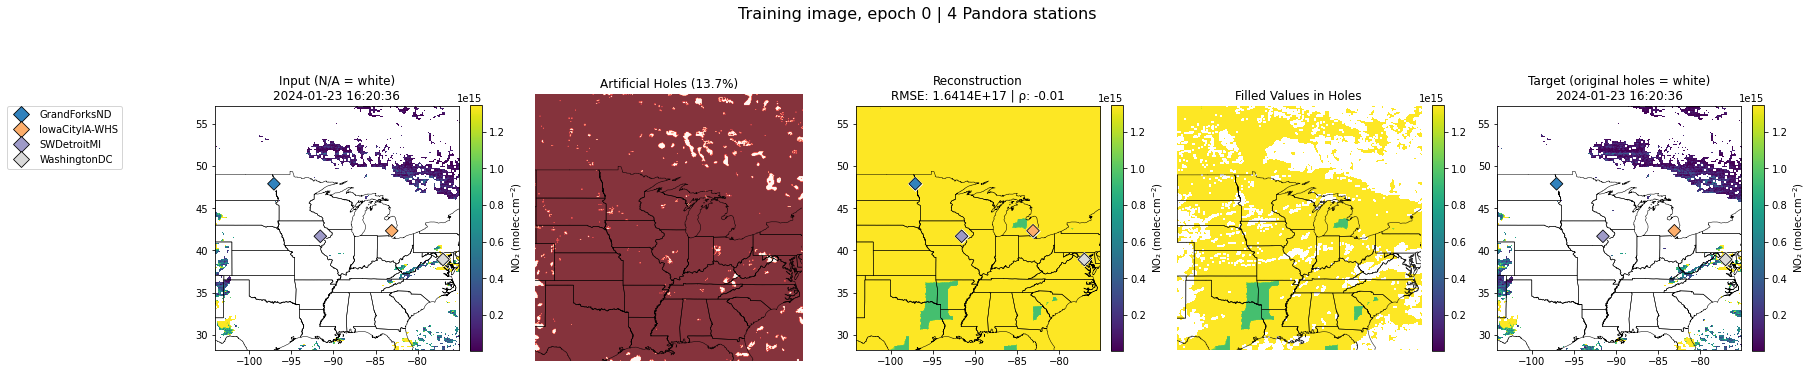

Fill percentage: 100.0%
Pandora RMSE: 1.4026E+17 (4 stations)
Pandora correlation (ρ): -0.800


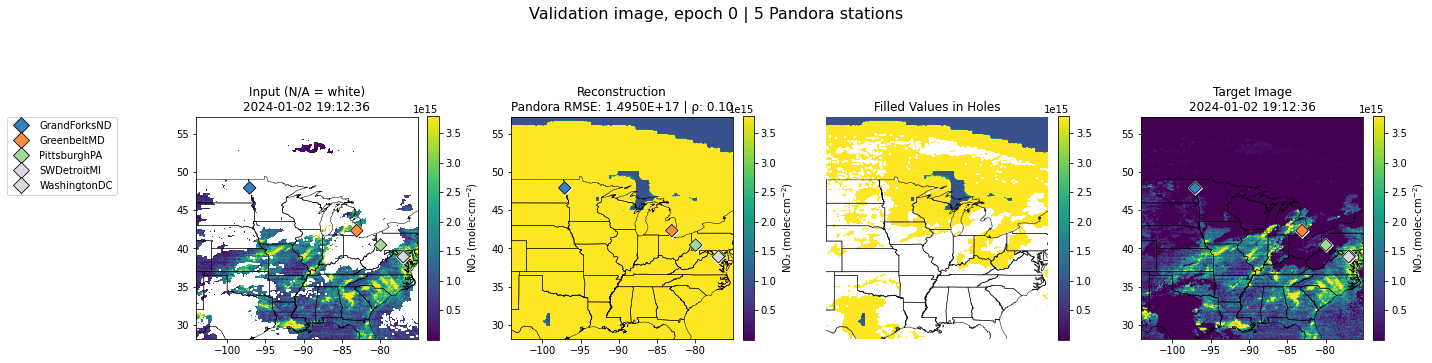

  0%|          | 1/4171 [00:10<12:06:09, 10.45s/it]

Fill percentage: 100.0%
Pandora RMSE: 1.4950E+17 (5 stations)
Pandora correlation (ρ): 0.100
{'rmse': 115.92655356005586, 'mae': 60.802276611328125, 'r2': -11837.935196007062, 'pandora_rmse': 1.5605353730455722e+17, 'pandora_mae': 1.2827101187741979e+17, 'pandora_rho': -0.20701966780270628, 'pandora_r2': -16164.219868453385, 'n_pandora_stations': 6}


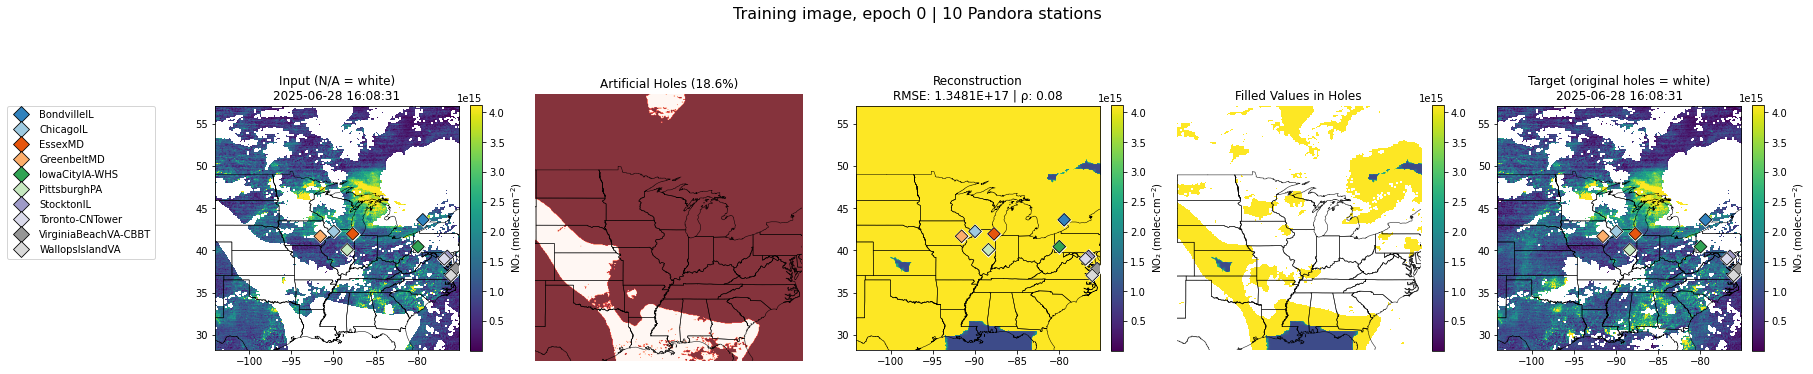

Fill percentage: 100.0%
Pandora RMSE: 1.8772E+17 (10 stations)
Pandora correlation (ρ): -0.522


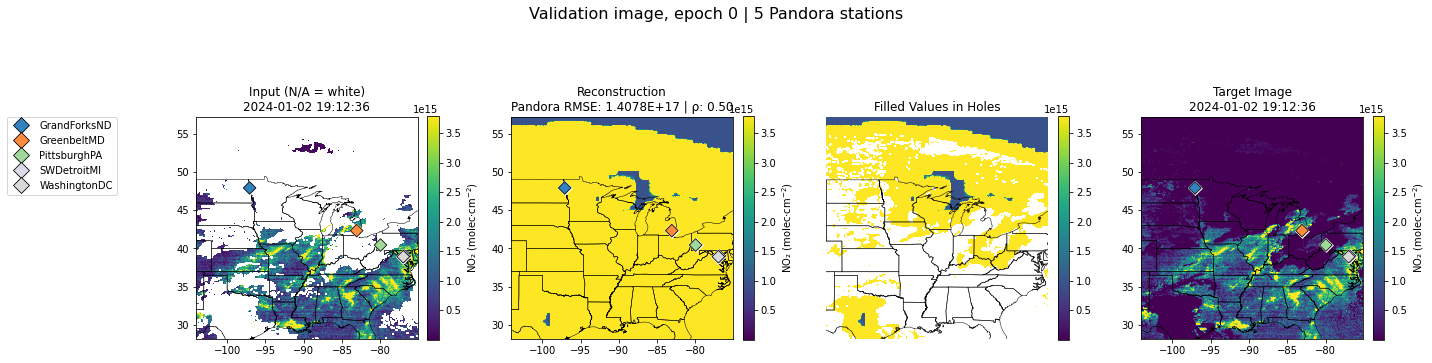

  0%|          | 2/4171 [00:19<11:18:26,  9.76s/it]

Fill percentage: 100.0%
Pandora RMSE: 1.4078E+17 (5 stations)
Pandora correlation (ρ): 0.500
{'rmse': 194.52298426214318, 'mae': 138.86700439453125, 'r2': -30649.994153145606, 'pandora_rmse': 1.784695664522028e+17, 'pandora_mae': 1.6849089737481546e+17, 'pandora_rho': 0.27386127875258304, 'pandora_r2': -12381.899817462216, 'n_pandora_stations': 9}


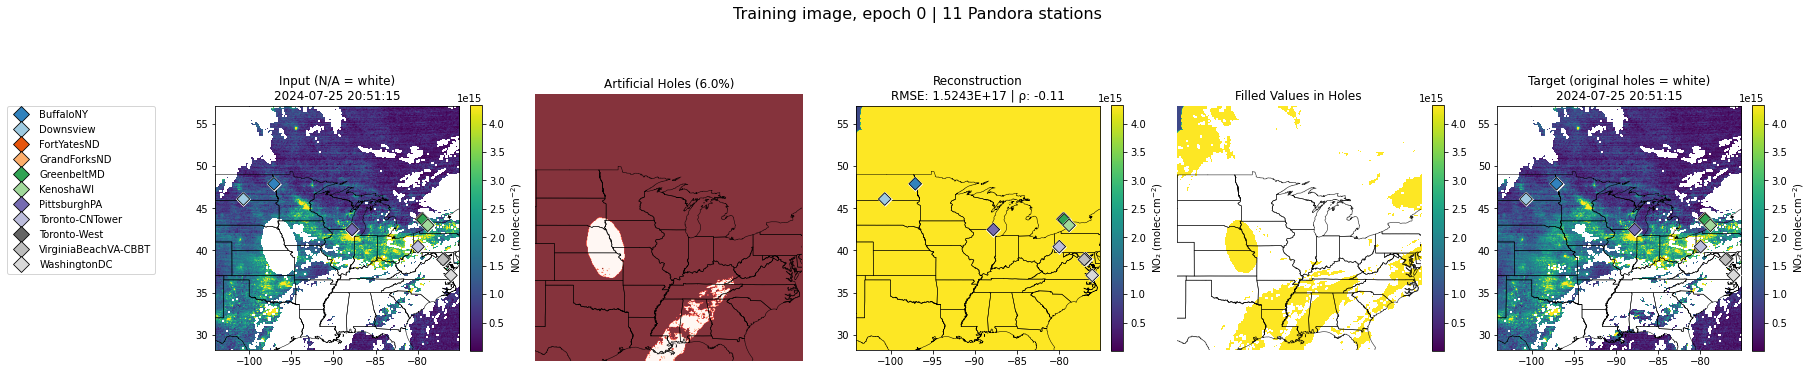

Fill percentage: 100.0%
Pandora RMSE: 1.7465E+17 (11 stations)
Pandora correlation (ρ): -0.516


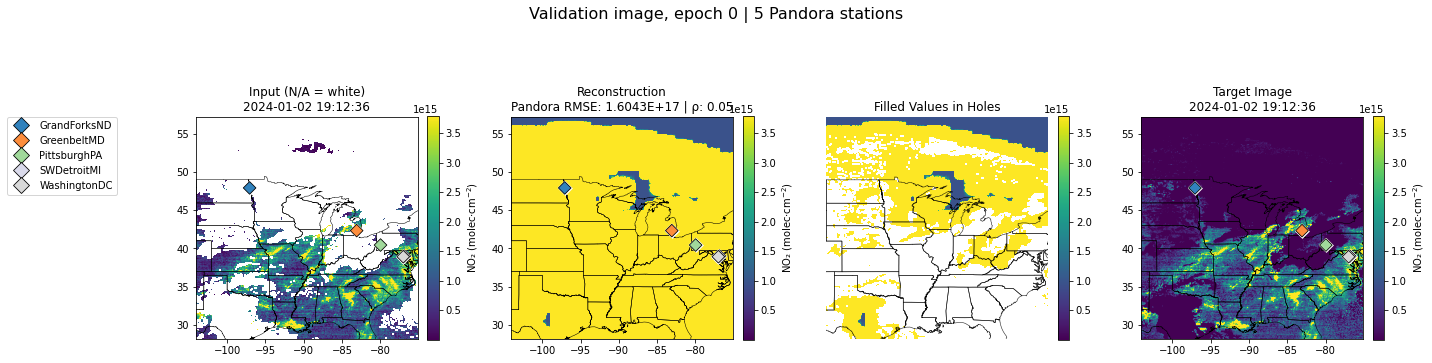

  0%|          | 3/4171 [00:28<10:59:46,  9.50s/it]

Fill percentage: 100.0%
Pandora RMSE: 1.6043E+17 (5 stations)
Pandora correlation (ρ): 0.051
{'rmse': 119.61125998677967, 'mae': 69.19788360595703, 'r2': -10389.006889786862, 'pandora_rmse': 1.6896969950038077e+17, 'pandora_mae': 1.5123754083678768e+17, 'pandora_rho': 0.3113995776646092, 'pandora_r2': -2246.922124837727, 'n_pandora_stations': 10}


  0%|          | 3/4171 [00:31<12:10:39, 10.52s/it]


KeyboardInterrupt: 

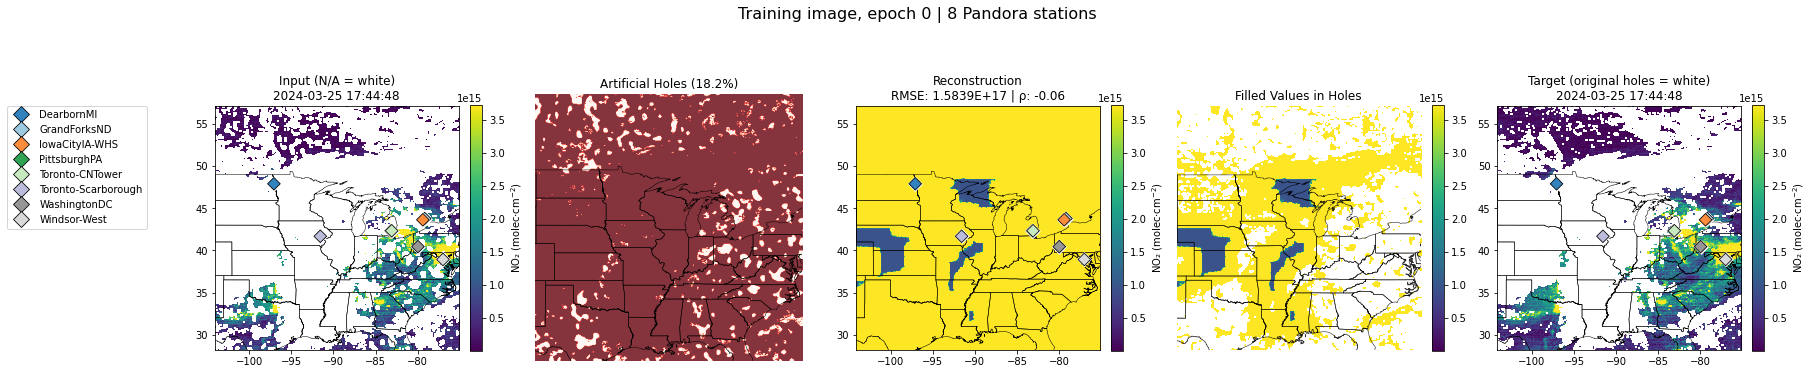

In [19]:
def train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    
    wait = 0

    history = []
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch["p_mask"]
            p_val_map = batch["p_val_mask"]

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            loss = improved_loss(pred_t, target, mask_aug)            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
#             visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
#                     batch_idx=0, sample_idx=0, device="cuda", save=True, train=True, shp_path=shp_path)
            
#             visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
#                     batch_idx=0, sample_idx=0, device="cuda", save=True, train=False, shp_path=shp_path)
        
        
            
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(
                pred_t, target, mask_aug, known_mask, 
                p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            print(batch_metrics)
            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            batch_count += 1
            for key in train_metrics:
                train_metrics[key] /= batch_count
                
#             visualize_batch(epoch, model,normalizer, train_loader, device="cuda",train=True, shp_path=shp_path,save=False)

#             visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path,save = False)
        # Average metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch['p_mask']
                p_val_map = batch["p_val_mask"]

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None
                    
                pred, _ = model(img, mask)
                loss = improved_loss(pred, target, mask)
                val_loss += loss.item()
                
                # Calculate metrics for fake mask regions
                batch_metrics = calculate_metrics(
                pred_t, target, mask_aug, known_mask, 
                p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

                batch_metrics = calculate_metrics(pred, target, mask, mask)
                for key in batch_metrics:
                    val_metrics[key] += batch_metrics[key]
                batch_count += 1
                
        val_loss /= len(val_loader)
       
        visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path,save = False)
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "train_loss", "val_loss", 
                "train_rmse", "train_mae", "train_r2",
                "pred_min_range", "pred_max_range"
            ])
            writer.writeheader()
            writer.writerows(history)
            
        if epoch % 2 == 0: 
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=True, shp_path=shp_path)
            
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=False, shp_path=shp_path)
        
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = OriginalPlusMinimalAttention(base_ch=32).cuda()  # Your original + tiny attention
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)

  0%|          | 0/522 [00:00<?, ?it/s]

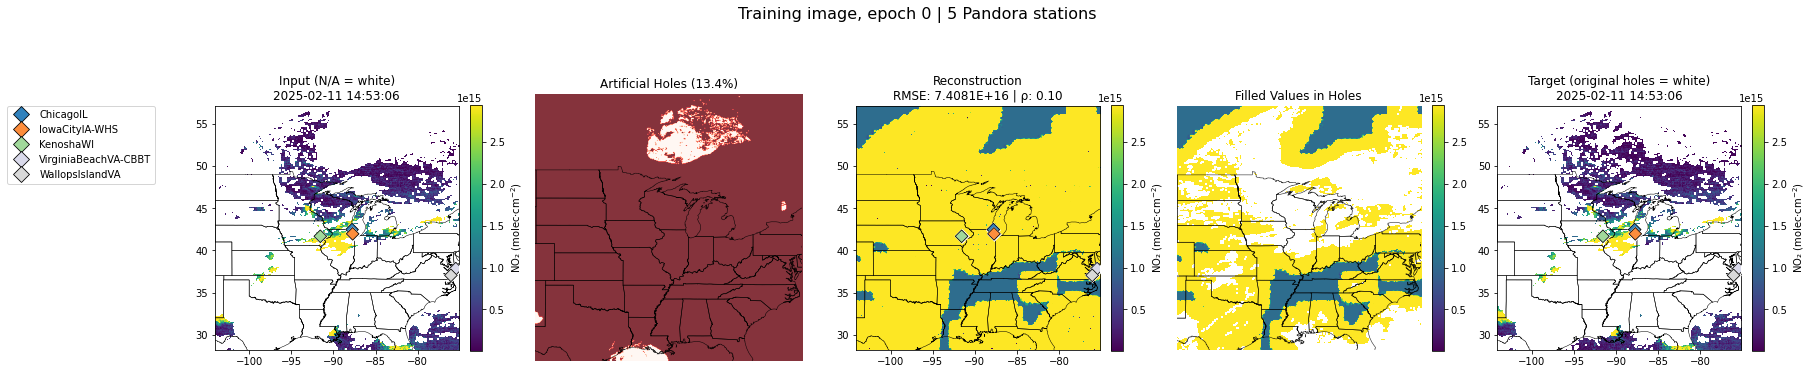

Pandora RMSE: 7.5518E+16 (5 stations)
Pandora correlation (ρ): 0.800


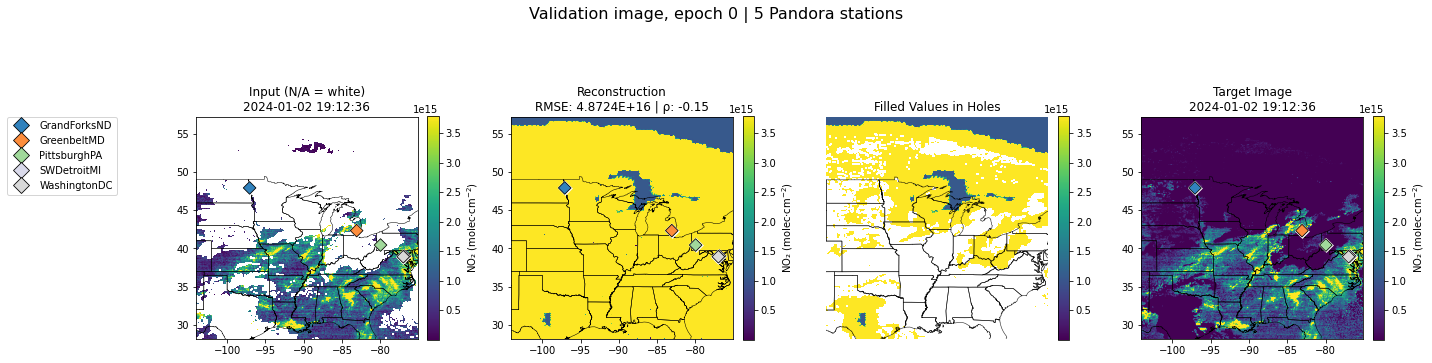

  0%|          | 1/522 [00:08<1:14:35,  8.59s/it]

Pandora RMSE: 4.8724E+16 (5 stations)
Pandora correlation (ρ): -0.154


  0%|          | 1/522 [00:11<1:42:30, 11.81s/it]


KeyboardInterrupt: 

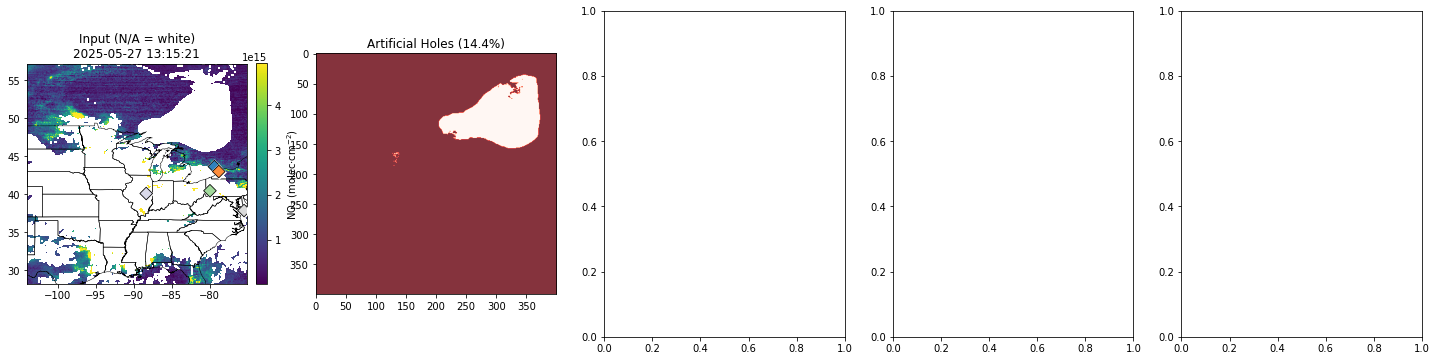

In [20]:
def train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0
    history = []
    
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,'n_pandora_stations': 0}
        train_batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch["p_mask"]
            p_val_map = batch["p_val_mask"]

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            loss = improved_loss(pred_t, target, mask_aug)            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
        
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug, known_mask, 
                                              p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            train_batch_count += 1
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=shp_path)
            
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=False, train=False, shp_path=shp_path)
        
            
        for key in train_metrics:
            train_metrics[key] /= train_batch_count
        train_loss /= len(train_loader)

        # ---- Validation (Simple Version) ----
        model.eval()
        val_loss = 0
        val_metrics = {
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        val_batch_count = 0

        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch["p_mask"]
                p_val_map = batch["p_val_mask"]

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None

                pred, _ = model(img, mask)
                loss = improved_loss(pred, target, mask)
                val_loss += loss.item()

                # Calculate metrics for first sample in batch only (faster)
                batch_metrics = calculate_metrics(
                    pred, target, mask, mask,  # Use known_mask for both
                    p_mask=p_mask, p_values=p_val_map, normalizer=normalizer,
                )

                # Add to validation totals
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key]

                val_batch_count += 1

        # Average validation metrics and loss over all batches
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= val_batch_count

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
                  
        if val_metrics['n_pandora_stations'] > 0:
            print(f"Val Pandora metrics - RMSE: {val_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {val_metrics['pandora_mae']:.4E}, "
                  f"ρ: {val_metrics['pandora_rho']:.2f}, "
                  f"R²: {val_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        # Store all metrics in history
        epoch_data = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "train_pandora_rmse": train_metrics['pandora_rmse'],
            "train_pandora_mae": train_metrics['pandora_mae'],
            "train_pandora_rho": train_metrics['pandora_rho'],
            "train_pandora_r2": train_metrics['pandora_r2'],
            "train_n_pandora_stations": train_metrics['n_pandora_stations'],
            "val_pandora_rmse": val_metrics['pandora_rmse'],
            "val_pandora_mae": val_metrics['pandora_mae'],
            "val_pandora_rho": val_metrics['pandora_rho'],
            "val_pandora_r2": val_metrics['pandora_r2'],
            "val_n_pandora_stations": val_metrics['n_pandora_stations'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        }
        history.append(epoch_data)
        
        if epoch % 2 == 0: 
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=True, shp_path=shp_path)
            
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=False, shp_path=shp_path)
        
        # Write all metrics to CSV
        fieldnames = [
            "epoch", "train_loss", "val_loss", 
            "train_rmse", "train_mae", "train_r2",
            "train_pandora_rmse", "train_pandora_mae", "train_pandora_rho", "train_pandora_r2", "train_n_pandora_stations",
            "val_pandora_rmse", "val_pandora_mae", "val_pandora_rho", "val_pandora_r2", "val_n_pandora_stations",
            "pred_min_range", "pred_max_range"
        ]
        
        with open('csv_history.csv', "w", newline="") as f:
            csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
            csv_writer.writeheader()
            csv_writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model
train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

# Use the custom collate function in your DataLoader
train_loader = DataLoader(
    train_ds, 
    batch_size=8, 
    shuffle=True,
    collate_fn=custom_collate_fn  # Add this line
)

val_loader = DataLoader(
    val_ds, 
    batch_size=8, 
    shuffle=False,
    collate_fn=custom_collate_fn  # Add this line
)
model = OriginalPlusMinimalAttention(base_ch=32).cuda()  # Your original + tiny attention
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)